### User Generosity Weights Feature Generator

- Goal: Quantify how lenient or strict each user's rating behaviour is.
- Compute each user's average rating across all their reviews.
- Identify harshest and most generous raters across users.
- Apply min-max normalisation to rescale user means to a [0, 1] generosity score.
- Optionally include number of reviews per user to gauge reliability.
- Save per-user table (user_id, mean_rating, n_reviews, generosity_weight).
- Use later as a user-level feature in NCF or to adjust rating bias.

In [10]:
from pathlib import Path
import pandas as pd
import numpy as np

# Project paths
ROOT = Path("../..").resolve()
DATA_PROCESSED = ROOT / "data" / "processed"
REVIEWS_PATH = DATA_PROCESSED / "sf-reviews.json"
REVIEWS_SAMPLED_PATH = DATA_PROCESSED / "sf-sampled-reviews.json"

OUT_DIR = DATA_PROCESSED / "features" / "usergen"
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [11]:
from pathlib import Path
import pandas as pd
import numpy as np

# Project paths
ROOT = Path("../..").resolve()
DATA_PROCESSED = ROOT / "data" / "processed"
REVIEWS_PATH = DATA_PROCESSED / "sf-reviews.json"
REVIEWS_SAMPLED_PATH = DATA_PROCESSED / "sf-sampled-reviews.json"

OUT_DIR = DATA_PROCESSED / "features" / "usergen"
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [12]:
from pathlib import Path
import pandas as pd
import numpy as np

# Project paths
ROOT = Path("../..").resolve()
DATA_PROCESSED = ROOT / "data" / "processed"
REVIEWS_PATH = DATA_PROCESSED / "sf-reviews.json"
REVIEWS_SAMPLED_PATH = DATA_PROCESSED / "sf-sampled-reviews.json"

OUT_DIR = DATA_PROCESSED / "features" / "usergen"
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [13]:
def read_json_in_chunks(file_path, chunk_size=10000):
    """Read large JSON file in chunks"""
    chunks = []
    
    with open(file_path, 'r') as file:
        chunk = []
        for i, line in enumerate(file):
            chunk.append(line)
            
            if (i + 1) % chunk_size == 0:
                chunk_df = pd.read_json('\n'.join(chunk), lines=True)
                chunks.append(chunk_df)
                chunk = []  
        
        # process remaining lines
        if chunk:
            chunk_df = pd.read_json('\n'.join(chunk), lines=True)
            chunks.append(chunk_df)
    
    return pd.concat(chunks, ignore_index=True)

# Try to load sampled reviews first, fallback to full reviews
try:
    print(f"Loading sampled reviews from {REVIEWS_SAMPLED_PATH}...")
    reviews_df = read_json_in_chunks(REVIEWS_SAMPLED_PATH)
    print(f"Loaded {len(reviews_df)} reviews from sampled file")
except FileNotFoundError:
    print(f"Sampled file not found, loading full reviews from {REVIEWS_PATH}...")
    reviews_df = read_json_in_chunks(REVIEWS_PATH)
    print(f"Loaded {len(reviews_df)} reviews from full file")

# Convert user_id to string for consistency
reviews_df['user_id'] = reviews_df['user_id'].astype(str)
print(f"\nReviews DataFrame shape: {reviews_df.shape}")
print(f"Columns: {reviews_df.columns.tolist()}")
print(f"\nFirst few rows:")
reviews_df.head()

Loading sampled reviews from /Users/jaslyntay/BT4222 Project/GoogleMaps_Recommender/data/processed/sf-sampled-reviews.json...


/var/folders/hk/m4hsrlxd6bng2k47fb3310lc0000gn/T/ipykernel_8649/3768437427.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  chunk_df = pd.read_json('\n'.join(chunk), lines=True)
/var/folders/hk/m4hsrlxd6bng2k47fb3310lc0000gn/T/ipykernel_8649/3768437427.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  chunk_df = pd.read_json('\n'.join(chunk), lines=True)
/var/folders/hk/m4hsrlxd6bng2k47fb3310lc0000gn/T/ipykernel_8649/3768437427.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  chunk_df = pd.read_json('\n'.join(chunk), lines=True)
/var/folders/hk/m4hsrlxd6bng2k47fb3310lc0000gn/T/ipykernel_8649/3768437427.py:1

Loaded 411496 reviews from sampled file

Reviews DataFrame shape: (411496, 6)
Columns: ['user_id', 'name', 'time', 'rating', 'text', 'gmap_id']

First few rows:


,user_id,name,time,rating,text,gmap_id
0,1.111581421e+20,Tiffany Duong,1412890409813,5,Lazing your day away in cafes is one of the be...,0x1532f63595a49fdd:0xac59d1857e129a53
1,1.0303224790000001e+20,JaeKwon Son,1552143019447,4,None,0x1532f63595a49fdd:0xac59d1857e129a53
2,1.039197287e+20,Samantha Andonian,1575754575457,4,None,0x1532f63595a49fdd:0xac59d1857e129a53
3,1.120315816e+20,Ev,1481342473506,4,A longtime favorite neighborhood spot. Don't t...,0x1532f63595a49fdd:0xac59d1857e129a53
4,1.183536215e+20,Daniel Ramsay,1503152603542,4,Wonderful french brasserie in a great location...,0x1532f63595a49fdd:0xac59d1857e129a53


In [14]:
user_stats = (
    reviews_df
    .groupby('user_id')
    .agg(
        mean_rating=('rating', 'mean'),
        n_reviews=('rating', 'count')
    )
    .reset_index()
)


In [15]:
print("Computing confidence-adjusted generosity weights...")

# Step 1: Normalize mean ratings to [0, 1]
# Captures generosity sentiment, independent of review volume
min_rating = user_stats['mean_rating'].min()
max_rating = user_stats['mean_rating'].max()
rating_range = max_rating - min_rating

if rating_range > 0:
    user_stats['normalized_mean'] = (user_stats['mean_rating'] - min_rating) / rating_range
else:
    user_stats['normalized_mean'] = 0.5  # fallback if all ratings are identical

# Step 2: Compute confidence from review count using log-scaling
# Formula: log1p(n) / log1p(max_n)
# Smoothly increases with review count, but flattens at the top
user_stats['confidence'] = np.log1p(user_stats['n_reviews']) / np.log1p(user_stats['n_reviews'].max())

# Step 3: Combine generosity sentiment with confidence
# Final generosity weight = normalized_mean × confidence
# Penalizes noisy users with few reviews, rewards consistent generosity
user_stats['generosity_weight'] = user_stats['normalized_mean'] * user_stats['confidence']

# Step 4: Inspect distribution
print("\nGenerosity weight statistics (confidence-adjusted):")
print(user_stats['generosity_weight'].describe())

# Step 5: Sanity check — all scores should be in [0, 1]
assert user_stats['generosity_weight'].min() >= 0, "Generosity weight should be >= 0"
assert user_stats['generosity_weight'].max() <= 1, "Generosity weight should be <= 1"

# Step 6: Preview top users
user_stats.head(10)




Computing confidence-adjusted generosity weights...

Generosity weight statistics (confidence-adjusted):
count    131972.000000
mean          0.285438
std           0.161669
min           0.000000
25%           0.203795
50%           0.203795
75%           0.373624
max           0.990032
Name: generosity_weight, dtype: float64


,user_id,mean_rating,n_reviews,normalized_mean,confidence,generosity_weight
0,1.0000002320000002e+20,4.000000,2,0.750000,0.323008,0.242256
1,1.0000010660000001e+20,4.375000,24,0.843750,0.946395,0.798521
2,1.000001862e+20,5.000000,1,1.000000,0.203795,0.203795
3,1.000003783e+20,3.000000,1,0.500000,0.203795,0.101898
4,1.000007151e+20,4.666667,3,0.916667,0.407590,0.373624
5,1.0000078029999999e+20,5.000000,2,1.000000,0.323008,0.323008
6,1.0000091639999999e+20,3.500000,2,0.625000,0.323008,0.201880
7,1.000012515e+20,5.000000,2,1.000000,0.323008,0.323008
8,1.000016743e+20,3.000000,1,0.500000,0.203795,0.101898
9,1.00001824e+20,4.500000,2,0.875000,0.323008,0.282632


In [16]:
# Prepare final output table
user_generosity = user_stats[['user_id', 'mean_rating', 'n_reviews', 'generosity_weight']].copy()

# Ensure proper data types
user_generosity['user_id'] = user_generosity['user_id'].astype(str)
user_generosity['mean_rating'] = user_generosity['mean_rating'].astype(np.float32)
user_generosity['n_reviews'] = user_generosity['n_reviews'].astype(np.int32)
user_generosity['generosity_weight'] = user_generosity['generosity_weight'].astype(np.float32)

print("Final user generosity table:")
print(user_generosity.head(10))
print(f"\nTable shape: {user_generosity.shape}")

Final user generosity table:
                  user_id  mean_rating  n_reviews  generosity_weight
0  1.0000002320000002e+20     4.000000          2           0.242256
1  1.0000010660000001e+20     4.375000         24           0.798521
2         1.000001862e+20     5.000000          1           0.203795
3         1.000003783e+20     3.000000          1           0.101898
4         1.000007151e+20     4.666667          3           0.373624
5  1.0000078029999999e+20     5.000000          2           0.323007
6  1.0000091639999999e+20     3.500000          2           0.201880
7         1.000012515e+20     5.000000          2           0.323007
8         1.000016743e+20     3.000000          1           0.101898
9          1.00001824e+20     4.500000          2           0.282632

Table shape: (131972, 4)


In [17]:
# Save to parquet file
import pyarrow as pa
import pyarrow.parquet as pq

OUTPUT_FILE = OUT_DIR / "user_generosity_weights.parquet"

# Create schema
schema = pa.schema([
    pa.field('user_id', pa.string()),
    pa.field('mean_rating', pa.float32()),
    pa.field('n_reviews', pa.int32()),
    pa.field('generosity_weight', pa.float32())
])

# Convert to PyArrow table
table = pa.Table.from_pandas(user_generosity, schema=schema, preserve_index=False)

# Write to parquet
pq.write_table(table, OUTPUT_FILE)

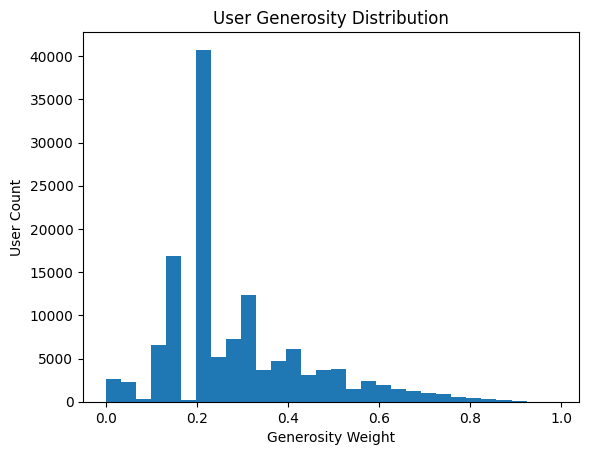

In [18]:
import matplotlib.pyplot as plt
plt.hist(user_stats['generosity_weight'], bins=30)
plt.title("User Generosity Distribution")
plt.xlabel("Generosity Weight")
plt.ylabel("User Count")
plt.show()


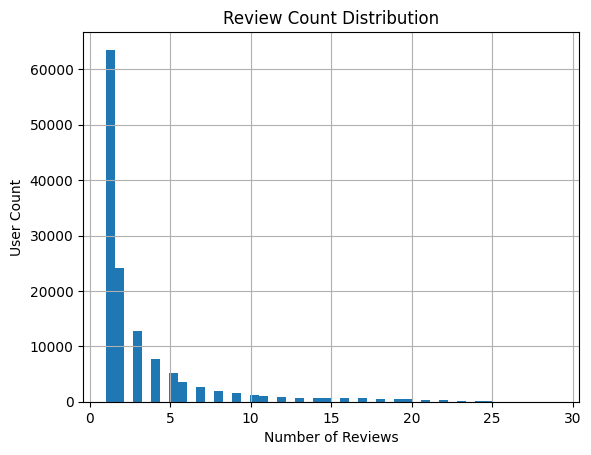

In [19]:
user_stats['n_reviews'].hist(bins=50)
plt.title("Review Count Distribution")
plt.xlabel("Number of Reviews")
plt.ylabel("User Count")
plt.show()
